In [1]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import os
import random

## Prep

In [2]:
#read the datasets
avg_retail = pd.read_csv('data/BrandAverageRetailPrice.csv')
details = pd.read_csv('data/BrandDetails.csv')
total_sales = pd.read_csv('data/BrandTotalSales.csv')
total_units = pd.read_csv('data/BrandTotalUnits.csv')
customers = pd.read_csv('data/cust.csv')
data_dict = pd.read_csv('data/DataDictionary.csv')
top_50 = pd.read_csv('data/Top50ProductsbyTotalSales-TimeSeries.csv')

In [3]:
#set names for dataframes
avg_retail.name = 'Average Retail'
details.name = 'Brand Details'
total_sales.name = 'Brand Total Sales'
total_units.name = 'Brand_Total Units'
customers.name = 'Customers'
data_dict.name = 'Data Dictionary'
top_50.name = 'Top 50 Products by Total Sales'

In [4]:
#container to keep track of all datasets
my_data = [avg_retail, details, total_sales, total_units, customers, data_dict, top_50]

## Look at Data

In [5]:
#look at info about dataframes using head and info functions
for df in my_data:
    print(df.name)
    print(df.head())
    print(df.info(), '\n')

Average Retail
         Brands   Months        ARP  vs. Prior Period
0  #BlackSeries  08/2020  15.684913               NaN
1  #BlackSeries  09/2020        NaN         -1.000000
2  #BlackSeries  01/2021  13.611428               NaN
3  #BlackSeries  02/2021  11.873182         -0.127705
4  #BlackSeries  03/2021        NaN         -1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27211 entries, 0 to 27210
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brands            27211 non-null  object 
 1   Months            27211 non-null  object 
 2   ARP               25279 non-null  float64
 3   vs. Prior Period  24499 non-null  float64
dtypes: float64(2), object(2)
memory usage: 850.5+ KB
None 

Brand Details
        State   Channel  Category L1   Category L2            Category L3  \
0  California  Licensed  Inhaleables        Flower                 Hybrid   
1  California  Licensed  Inhaleables      

## Clean up some of the dataframes

Some of the dataframes have columns we cannot use with just unnamed and missing columns

<br>

Dataframes in question:

    - data_dict
    - customers


In [6]:
data_dict.head()

,Feature Name,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,State,State where the sales occurred (for our datase...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Channel,Options between legal (licensed) and grey mark...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Category L1,Highest-level category for product. Options in...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Category L2,Next layer of categorization. Multiple product...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Category L3,Further detail on product-type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
customers.head()

,customerid,name,years,spent,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,Customers,2,2500,NaN,NaN,NaN
1,2,Customers,4,1300,NaN,NaN,NaN
2,3,Customers,5,2400,NaN,NaN,NaN


In [8]:
#trimming to only have useful columns
data_dict = data_dict[['Feature Name', 'Description']]
customers = customers[['customerid', 'name', 'years', 'spent']]

In [9]:
data_dict.head()

,Feature Name,Description
0,State,State where the sales occurred (for our datase...
1,Channel,Options between legal (licensed) and grey mark...
2,Category L1,Highest-level category for product. Options in...
3,Category L2,Next layer of categorization. Multiple product...
4,Category L3,Further detail on product-type


In [10]:
customers.head()

,customerid,name,years,spent
0,1,Customers,2,2500
1,2,Customers,4,1300
2,3,Customers,5,2400


Some dataframes need their information to be formatted in a way we can use it. Examples of how we can do this includes:
    
    - converting months to date time
    - changing numbers from string to float form

In [11]:
#cleaning avg_retail
avg_retail['Months'] = pd.to_datetime(avg_retail['Months'])

avg_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27211 entries, 0 to 27210
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27211 non-null  object        
 1   Months            27211 non-null  datetime64[ns]
 2   ARP               25279 non-null  float64       
 3   vs. Prior Period  24499 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 850.5+ KB


In [12]:
#clean total_sales
#convert months to date time 
total_sales['Months'] = pd.to_datetime(total_sales['Months'])
#change sales to float
total_sales['Total Sales ($)'] = total_sales['Total Sales ($)'].str.replace(',', '').astype(float)
total_sales['Total Sales ($)'] = pd.to_numeric(total_sales['Total Sales ($)'])

total_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


In [13]:
#clean total_units
#convert months to date time 
total_units['Months'] = pd.to_datetime(total_units['Months'])
#change units to float
total_units['Total Units'] = total_units['Total Units'].str.replace(',', '').astype(float)
total_units['Total Units'] = pd.to_numeric(total_units['Total Units'])

total_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


In [14]:
#clean up details 
#change total sales to float
details['Total Sales ($)'] = details['Total Sales ($)'].str.replace(',', '').astype(float)
details['Total Sales ($)'] = pd.to_numeric(details['Total Sales ($)'])

#changes units to float
details['Total Units'] = details['Total Units'].str.replace(',', '').astype(float)
details['Total Units'] = pd.to_numeric(details['Total Units'])

#change total thc to float
details['Total THC'] = details['Total THC'].str.replace(',', '').astype(float)
details['Total THC'] = pd.to_numeric(details['Total THC'])

#change total cbd to float
details['Total CBD'] = details['Total CBD'].str.replace(',', '').astype(float)
details['Total CBD'] = pd.to_numeric(details['Total CBD'])

## Time Series Feature Engineering, Merge Data, Develop New Features

    - break up data by brand
    - use data from other data frames to make new features
    - merge with other brands for overall dataset


In [15]:
brands = total_units['Brands'].unique()
print(len(brands))
print(brands)

1640
['#BlackSeries' '101 Cannabis Co.' '10x Infused' ... 'Zlixir' 'Zoma'
 'Zuma Topicals']


In [16]:
details.head()

,State,Channel,Category L1,Category L2,Category L3,Category L4,Category L5,Brand,Product Description,Total Sales ($),...,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,California,Licensed,Inhaleables,Flower,Hybrid,NaN,NaN,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),1103.964857,...,0.0,0.0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,California,Licensed,Inhaleables,Flower,Hybrid,NaN,NaN,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),674.645211,...,0.0,0.0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
2,California,Licensed,Inhaleables,Flower,Sativa Dominant,NaN,NaN,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),2473.699102,...,0.0,0.0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
3,California,Licensed,Inhaleables,Flower,Sativa Dominant,NaN,NaN,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),14589.916417,...,0.0,0.0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
4,California,Licensed,Inhaleables,Concentrates,Dabbable Concentrates,Wax,NaN,101 Cannabis Co.,101 Cannabis Co. - Afghan Kush - Wax,145.396270,...,0.0,0.0,THC Only,NaN,Afghan Kush,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99


In [17]:
df = pd.DataFrame()
for brand in brands:
    units = total_units[total_units.Brands == str(brand)]
    units.loc[:,'Previous Month'] = units.loc[:,'Total Units'].shift(1)
    units.loc[:,'Rolling Average'] = (units.loc[:,'Total Units'].shift(1) + units.loc[:,'Total Units'].shift(2) + units.loc[:,'Total Units'].shift(3))/3

    sales = total_sales[total_sales.Brand == str(brand)]
    units = units.merge(sales, left_on='Months', right_on='Months')
    units = units.drop(['Brand'], 1)
    
    brand_details = details[details.Brand == str(brand)]
    
    #new features using brand details 
    #number of products 
    units['Num Products'] = len(brand_details)
    
    #number strains 
    num_strain = len(brand_details['Strain'].unique())
    units['Num Strains'] = num_strain
    
    #num thc only products
    temp = brand_details['Contains CBD']
    counter = 0
    for i in temp:
        if i == 'THC Only':
            counter += 1
    units['Number THC Only Products'] = counter 
    
    #percentage thc only products
    if len(brand_details) == 0:
        units['Percent THC Only'] = float('Nan')
    else:
        units['Percent THC Only'] = counter / len(brand_details)
    
    
    #add to dataframe with other brands
    df = df.append(units)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [18]:
df.head(10)

,Brands,Months,Total Units,vs. Prior Period,Previous Month,Rolling Average,Total Sales ($),Num Products,Num Strains,Number THC Only Products,Percent THC Only
0,#BlackSeries,2020-08-01,1616.339004,NaN,NaN,NaN,25352.135918,4,2,4,1.0
1,#BlackSeries,2021-01-01,715.532838,NaN,NaN,NaN,9739.423400,4,2,4,1.0
2,#BlackSeries,2021-02-01,766.669135,0.071466,715.532838,NaN,9102.802187,4,2,4,1.0
0,101 Cannabis Co.,2019-11-01,131.067720,NaN,NaN,NaN,4465.040321,77,21,77,1.0
1,101 Cannabis Co.,2020-01-01,345.413448,NaN,NaN,NaN,11790.663567,77,21,77,1.0
2,101 Cannabis Co.,2020-02-01,696.658431,1.016883,345.413448,NaN,20266.761007,77,21,77,1.0
3,101 Cannabis Co.,2020-03-01,943.393328,0.354169,696.658431,NaN,30465.470533,77,21,77,1.0
4,101 Cannabis Co.,2020-04-01,712.498102,-0.244750,943.393328,661.821736,23465.657692,77,21,77,1.0
5,101 Cannabis Co.,2020-05-01,619.841032,-0.130045,712.498102,784.183287,21348.394472,77,21,77,1.0
6,101 Cannabis Co.,2020-06-01,426.150450,-0.312484,619.841032,758.577487,14111.757773,77,21,77,1.0


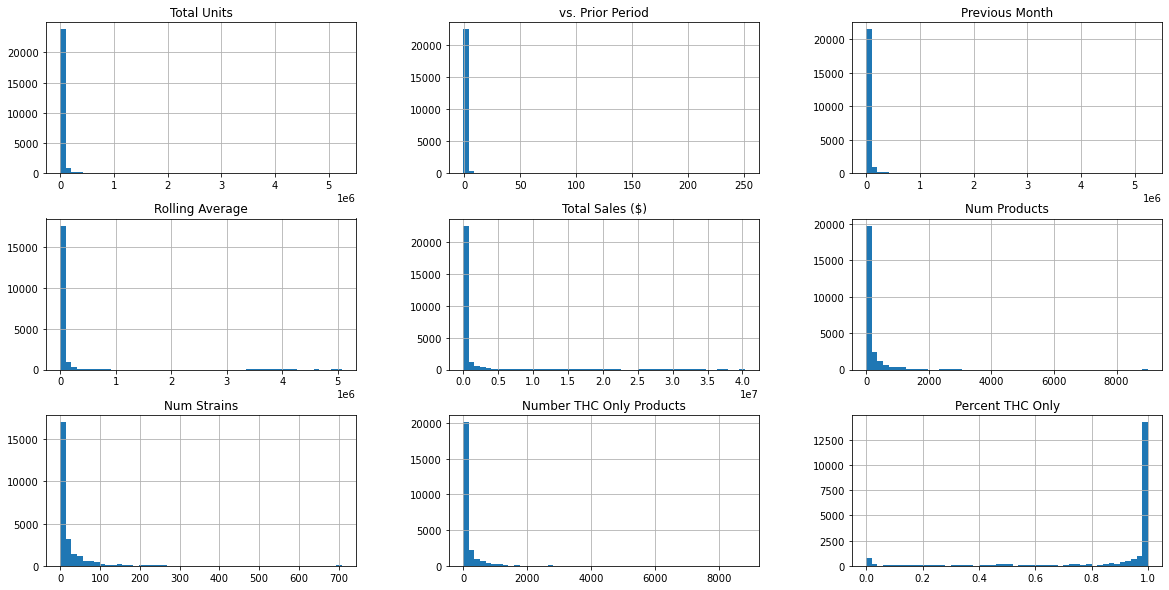

In [108]:
#visualizing my data
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(bins=50, figsize=(20, 10))
plt.show() 


In [20]:
#prep data 
x = df.drop('Total Sales ($)', axis = 1)
y = df['Total Sales ($)']

In [21]:
#split data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2)
print('xtrain shape:', xtrain.shape)
print('xtest shape:', xtest.shape)
print('ytrain shape:', ytrain.shape)
print('ytest shape:', ytest.shape)

xtrain shape: (20223, 10)
xtest shape: (5056, 10)
ytrain shape: (20223,)
ytest shape: (5056,)


In [22]:
x.head()

,Brands,Months,Total Units,vs. Prior Period,Previous Month,Rolling Average,Num Products,Num Strains,Number THC Only Products,Percent THC Only
0,#BlackSeries,2020-08-01,1616.339004,NaN,NaN,NaN,4,2,4,1.0
1,#BlackSeries,2021-01-01,715.532838,NaN,NaN,NaN,4,2,4,1.0
2,#BlackSeries,2021-02-01,766.669135,0.071466,715.532838,NaN,4,2,4,1.0
0,101 Cannabis Co.,2019-11-01,131.067720,NaN,NaN,NaN,77,21,77,1.0
1,101 Cannabis Co.,2020-01-01,345.413448,NaN,NaN,NaN,77,21,77,1.0


Categorical Features:
    
    Months
    Brands
    
Numerical Features:
    
    All other featuers

## Pipeline

In [23]:
#pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

categorical_features = ['Brands', 'Months']
numerical_features = [feat for feat in x.columns if feat not in categorical_features]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])


features_train_transformed = full_pipeline.fit_transform(x)
xpiped = features_train_transformed

In [24]:
#new split using pipelined data
xtrain, xtest, ytrain, ytest = train_test_split(xpiped, y, test_size = 0.2)
print('xtrain shape:', xtrain.shape)
print('xtest shape:', xtest.shape)
print('ytrain shape:', ytrain.shape)
print('ytest shape:', ytest.shape)


xtrain shape: (20223, 1672)
xtest shape: (5056, 1672)
ytrain shape: (20223,)
ytest shape: (5056,)


In [25]:
#regression results summary 
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Linear Regression

In [26]:
#implement linear regression
lr = LinearRegression()
lr.fit(xtrain, ytrain)
test_pred = lr.predict(xtest)
lr.score(xtest, ytest)

0.9494238233137843

In [27]:
regression_results(ytest, test_pred)

explained_variance:  0.9494
r2:  0.9494
MAE:  93367.1372
MSE:  126174475777.5105
RMSE:  355210.4669


## Ensemble Method Regression - Random Forest

In [28]:
#ensemble method - random forrest 
rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
rf_ypred = rf.predict(xtest)
rf.score(xtest, ytest)

0.9914594223997921

In [29]:
regression_results(ytest, rf_ypred)

explained_variance:  0.9915
r2:  0.9915
MAE:  45462.0019
MSE:  21306531496.6182
RMSE:  145967.57


## Implement PCA

Data was too complex and took forever to run. Use PCA to make it more simple

In [30]:
#data is too complex make it simpler
'''
pca = decomposition.PCA(n_components=4)
x_pca = pca.fit_transform(xpiped)
'''

'\npca = decomposition.PCA(n_components=4)\nx_pca = pca.fit_transform(xpiped)\n'

## Note
Tried to run PCA to make data better but the PCA was not supported.

Given the following error:
    
    PCA does not support sparse input. See TruncatedSVD for a possible alternative.
    
Will be running a truncatedSVD instead

In [75]:
#data is too complex, make it simpler
pca = TruncatedSVD(n_components=3)
x_pca = pca.fit_transform(xpiped)

xtrain, xtest, ytrain, ytest = train_test_split(x_pca, y, test_size = 0.2)

In [76]:
#redo linear regression
lr = LinearRegression()
lr.fit(xtrain, ytrain)
test_pred = lr.predict(xtest)

regression_results(ytest, test_pred)

explained_variance:  0.8831
r2:  0.8831
MAE:  199394.7118
MSE:  328627847603.2556
RMSE:  573260.7152


In [77]:
#redo ensemble method - random forrest 
rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
rf_ypred = rf.predict(xtest)
regression_results(ytest, rf_ypred)

explained_variance:  0.9654
r2:  0.9654
MAE:  83422.8955
MSE:  97322593412.6802
RMSE:  311965.6927


## Cross Validate with KFolds and GridSearchCV

In [78]:
#crossvalidation model paramters
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#range of paramters
hyper_params = [{'n_features_to_select': (1,2,3,4,5)}]

In [79]:
#grid search for linear regression
lr = LinearRegression()
lr.fit(xtrain, ytrain)
rfe = RFE(lr)

crossval_model = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      
crossval_model.fit(xtrain, ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': (1, 2, 3, 4, 5)}],
             return_train_score=True, scoring='r2', verbose=1)

In [80]:
crossval_results = pd.DataFrame(crossval_model.cv_results_)
crossval_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003794,0.001077,0.000716,0.000378,1,{'n_features_to_select': 1},0.808398,0.680290,0.785733,0.692648,...,0.754777,0.056480,5,0.751630,0.784275,0.761484,0.778163,0.752894,0.765689,0.013267
1,0.002652,0.000128,0.000525,0.000040,2,{'n_features_to_select': 2},0.895846,0.793614,0.858472,0.778257,...,0.839014,0.045283,4,0.832909,0.860587,0.846464,0.860695,0.842731,0.848677,0.010725
2,0.001816,0.000113,0.000533,0.000038,3,{'n_features_to_select': 3},0.897117,0.794025,0.860251,0.779494,...,0.840275,0.045555,1,0.834303,0.862141,0.847735,0.862072,0.844015,0.850053,0.010775
3,0.001889,0.000080,0.000593,0.000054,4,{'n_features_to_select': 4},0.897117,0.794025,0.860251,0.779494,...,0.840275,0.045555,1,0.834303,0.862141,0.847735,0.862072,0.844015,0.850053,0.010775
4,0.001743,0.000045,0.000545,0.000065,5,{'n_features_to_select': 5},0.897117,0.794025,0.860251,0.779494,...,0.840275,0.045555,1,0.834303,0.862141,0.847735,0.862072,0.844015,0.850053,0.010775


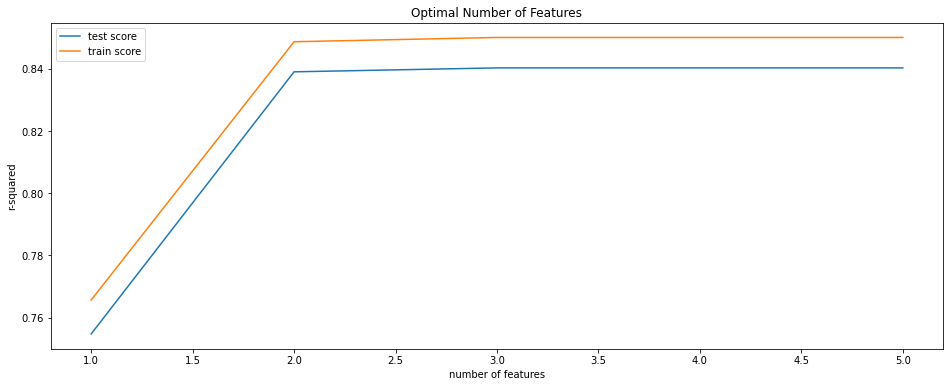

In [81]:
# plotting crossval results
plt.figure(figsize=(16,6))

plt.plot(crossval_results["param_n_features_to_select"], crossval_results["mean_test_score"])
plt.plot(crossval_results["param_n_features_to_select"], crossval_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'])

In [82]:
#grid search for random forrest 
rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
rfe = RFE(rf)

crossval_model = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      
crossval_model.fit(xtrain, ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=RandomForestRegressor()),
             param_grid=[{'n_features_to_select': (1, 2, 3, 4, 5)}],
             return_train_score=True, scoring='r2', verbose=1)

In [83]:
crossval_results = pd.DataFrame(crossval_model.cv_results_)
crossval_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.734009,0.318775,0.109537,0.003124,1,{'n_features_to_select': 1},0.885160,0.812093,0.828044,0.765243,...,0.829503,0.040711,5,0.974886,0.979389,0.978250,0.978721,0.976888,0.977627,0.001597
1,7.553310,0.101259,0.098317,0.000916,2,{'n_features_to_select': 2},0.974348,0.940616,0.956988,0.944704,...,0.956007,0.012299,4,0.993052,0.994577,0.994029,0.993798,0.993574,0.993806,0.000503
2,4.382365,0.035150,0.095261,0.002205,3,{'n_features_to_select': 3},0.981224,0.966631,0.975332,0.962601,...,0.972413,0.006794,3,0.995811,0.996325,0.996150,0.996090,0.996100,0.996095,0.000165
3,4.379332,0.047040,0.095048,0.002970,4,{'n_features_to_select': 4},0.982154,0.965752,0.976611,0.962911,...,0.972698,0.007212,2,0.995751,0.996410,0.996165,0.996110,0.996319,0.996151,0.000227
4,4.429725,0.068131,0.093585,0.000746,5,{'n_features_to_select': 5},0.981464,0.966351,0.976279,0.963623,...,0.972719,0.006670,1,0.995565,0.996519,0.996231,0.996384,0.996101,0.996160,0.000329


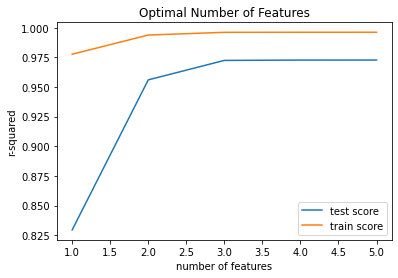

In [84]:
# plotting crossval results
plt.figure(figsize=(16,6))
%matplotlib inline
plt.plot(crossval_results["param_n_features_to_select"], crossval_results["mean_test_score"])
plt.plot(crossval_results["param_n_features_to_select"], crossval_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'])
plt.show()

## Bagging Regressor
    
    method of choice


In [85]:
bag = BaggingRegressor()
bag.fit(xtrain,ytrain)
bag_ypred = bag.predict(xtest)
regression_results(ytest, bag_ypred)

explained_variance:  0.9655
r2:  0.9655
MAE:  86984.4296
MSE:  97131452431.2056
RMSE:  311659.1928


In [90]:
#grid search cross val for bag
rfe = RFE(bag)

crossval_model = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      
crossval_model.fit(xtrain, ytrain)
crossval_results = pd.DataFrame(crossval_model.cv_results_)
crossval_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_rfe.py", line 151, in fit
    return self._fit(X, y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_rfe.py", line 204, in _fit
    raise RuntimeError('The classifier does not expose '
RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.8/site-packages/s

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   13.0s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.472460,0.013622,0.000000,0.000000,1,{'n_features_to_select': 1},NaN,NaN,NaN,NaN,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.473862,0.012873,0.000000,0.000000,2,{'n_features_to_select': 2},NaN,NaN,NaN,NaN,...,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.475292,0.014106,0.012247,0.001304,3,{'n_features_to_select': 3},0.978987,0.964425,0.974422,0.958106,...,0.969819,0.007519,2,0.993805,0.995308,0.994193,0.995008,0.994919,0.994647,0.000558
3,0.487780,0.031540,0.011847,0.001333,4,{'n_features_to_select': 4},0.978513,0.961099,0.973011,0.957767,...,0.968156,0.007663,3,0.993126,0.995532,0.994912,0.994916,0.994972,0.994691,0.000817
4,0.534654,0.070352,0.012208,0.000914,5,{'n_features_to_select': 5},0.979746,0.965881,0.975224,0.957412,...,0.970440,0.007902,1,0.994492,0.995473,0.995413,0.994436,0.994377,0.994838,0.000496


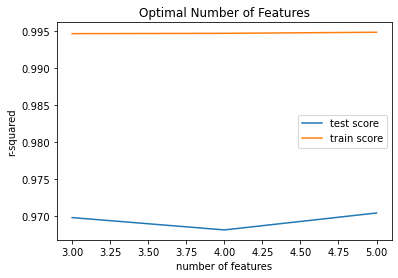

In [91]:
# plotting crossval results
plt.figure(figsize=(16,6))
%matplotlib inline
plt.plot(crossval_results["param_n_features_to_select"], crossval_results["mean_test_score"])
plt.plot(crossval_results["param_n_features_to_select"], crossval_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'])

# Report 

## Introduction
With my report I am aiming to model/predict the total sales of marijuana based on a variety of factors. From my background research, I learned that marijuana use seems to be steadily increasing as time goes on. The majority of marijuana use is located in the US with medical and recreational adult use being the largest streams of usage according to the BDSA. This may be due to the US legalizing the use of recreational marijuana where as many other countries have stricter laws. With my knowledge of data science modeling, I will try and predict the total sales based information given from brands to see how each brand’s growth is expected in the future. It is important to know the increase in sales as marijuana becomes a bigger part of our economy.

## Methodology
With my data I first had look at all the data and make sure they were in a form where I could use them. I had to get rid of columns that were not contributing any information as they would only take up unnecessary storage. I shaved off columns from customers and data dictionary. I then went through the rest of the dataframes and made sure to translate the data into a form where they could be used for any operations in mind. For example, the month column was in a string and I reformatted it to display as a date time. I also would go and change any numbers from a string to a float. 

With my data I decided to work mostly with the datasets concerning the brand. The information given by the brands allow me the most information. For example, the customers dataset only had 3 entries and the information was not enough for me to use. Similarly data dictionary had a very small set of information that I decided would not be as helpful as my other datasets. The Top 50 Products by Total Sales had a greater amount of information but it did not allow me the flexibility that the other data sets allowed. I ended up working primarily with the brand details, total units, and total sales. 

In order to separate the data and see how they all connected, I went through and created new features based on the brand of each product. I was able to combine information from the Total Sales and Total Units dataframes to be able to see how the products interacted with each other based on what time the sale was out. I also created features such as the number of products a brand had, the number of strains the brand holds, the number of THC only products and the percentage of THC only products that the brand sold. These new features were created by combining the information we had from the brand details page with the information we had from the units and sales dataframes. Something to note here was that the percentage of THC only products was created with two columns we had already created and may overlap in terms of information. 

As I had used a pipeline to make my data more expressive, running my data through the regressors was really slow. I decided to implement a principal analysis component (PCA) so that the data could run smoothly. The PCA made the data less dimensional and vastly decreased the runtime of my regressors as well as my cross validation executions possible (as they over an hour to run if I did not simplify my data with a pca). I decided to use a parameter of 3 components for my truncatedSVD as it allowed my data to be more complex than just 2 components but did not take an overwhelmingly long time to run.  
 
Some of the classifiers I trained my model were Linear Regression, Random Forest and Bagging regressors. The linear regressor is a single regressor and only shows one model where the Random Forest and Bagging regressors were ensemble methods. Ensemble methods are used as they show more depth in data as they combine multiple models. I chose these two ensemble methods as they were intuitive and easy to implement.  The random forrest was my choice for ensemble method as it a combination of decision trees and easy to understand. I also used the bagging regressor for my method of choice as it would allow for in-depth data compared to other single regressor classifiers. 

## Results

Data Shapes before Pipeline

    xtrain shape: (20223, 10)
    xtest shape: (5056, 10)
    ytrain shape: (20223,)
    ytest shape: (5056,)


Data Shapes after Pipeline

    xtrain shape: (20223, 1672)
    xtest shape: (5056, 1672)
    ytrain shape: (20223,)
    ytest shape: (5056,)


### Regression Summary before PCA

Linear:

    explained_variance:  0.9494
    r2:  0.9494
    MAE:  93367.1372
    MSE:  126174475777.5105
    RMSE:  355210.4669

Random Forrest:

    explained_variance:  0.9915
    r2:  0.9915
    MAE:  45462.0019
    MSE:  21306531496.6182
    RMSE:  145967.57

### Regression Summary after PCA

Linear:

    explained_variance:  0.8831
    r2:  0.8831
    MAE:  199394.7118
    MSE:  328627847603.2556
    RMSE:  573260.7152

Random Forrest:

    explained_variance:  0.9654
    r2:  0.9654
    MAE:  83422.8955
    MSE:  97322593412.6802
    RMSE:  311965.6927

Bagging:

    explained_variance:  0.9655
    r2:  0.9655
    MAE:  86984.4296
    MSE:  97131452431.2056
    RMSE:  311659.1928


Optimal Features Minimum 

    Linear: 2
    Random Forest: 3
    Bagging: 4


## Discussion:

Overall, we see a lot of high R^2 values which indicates the models are performing well. We do see a slight drop in R^2 values from before to after including the PCA. This is due to the PCA limiting the amount of components we can have. Due to the limited amount of componenents that are used the data is less expressive and then will be less acurrate as we train and test our models. 

The complexity decrease in the training and testing sets comes from the inclusion of the PCA. This really helped the data be processed in a more effcient manner. It is also possible that there may be overfitting if we did not used the PCA as it would be too complex and specific to this set of data. 

From the cross validation with kfolds and grid search, we see that the optimal amount of features around 2-4. This may be due the PCA components being 3 but this also shows that we do not need too many features to have a good model.


